In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import sys 
sys.path.append('../')
from pred_opt import get_lognormal_pars

A predição abaixo foi gerada a partir do código disponibilizado pelo BB-model (modelo do Leo Bastos) [aqui](https://github.com/lsbastos/bb-m):

In [2]:
df = pd.read_csv('comp_parametric/preds.csv')

df.head()

,uf,week,pred,lower_95,lower_90,lower_80,lower_50,upper_50,upper_80,upper_90,upper_95,date
0,AC,1,49.0,5,8,12,25,91,160,243,324,2024-10-06
1,AC,2,57.0,6,10,15,29,108,195,275,336,2024-10-13
2,AC,3,68.0,7,11,18,34,128,234,321,417,2024-10-20
3,AC,4,80.0,8,13,20,39,149,269,382,516,2024-10-27
4,AC,5,89.0,11,17,24,46,177,311,449,593,2024-11-03


In [3]:
#df_pred['date'] = pd.to_datetime(df_pred['date'])

df['date'] = pd.to_datetime(df['date'])

df_sp = df.loc[df.uf == 'SP']

df_sp.head()

,uf,week,pred,lower_95,lower_90,lower_80,lower_50,upper_50,upper_80,upper_90,upper_95,date
1248,SP,1,967.5,313,371,448,635,1596,3074,4511,7684,2024-10-06
1249,SP,2,1036.0,317,375,462,650,1768,3182,4859,7462,2024-10-13
1250,SP,3,1108.5,336,407,504,705,1855,3199,4977,7824,2024-10-20
1251,SP,4,1150.5,343,419,519,752,1964,3502,5514,8649,2024-10-27
1252,SP,5,1230.0,372,455,558,804,2052,3785,5797,8807,2024-11-03


### Compare the different log normal parameters: 

In [4]:
df_sp_peak = df_sp.loc[df_sp.pred == df_sp.pred.max()]

df_sp_peak.to_csv('comp_parametric/preds_peak.csv', index = False)

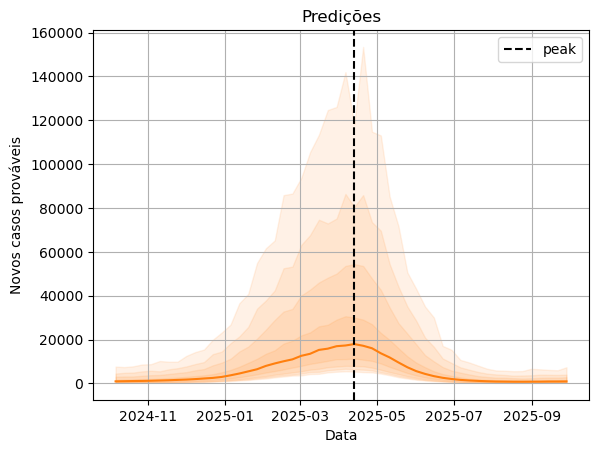

In [5]:
_,ax = plt.subplots()

ax.plot(df_sp.date, df_sp.pred, color = 'tab:orange')

for v in [50, 80, 90, 95]:
    ax.fill_between(df_sp.date, df_sp[f'lower_{v}'], df_sp[f'upper_{v}'], color = 'tab:orange', alpha = 0.1)

ax.grid()
ax.axvline(df_sp_peak['date'], linestyle = '--', color = 'black', label  ='peak')

ax.legend()

ax.set_title('Predições')
ax.set_xlabel('Data')
ax.set_ylabel('Novos casos prováveis')
plt.savefig('comp_parametric/preds.png', dpi = 300, bbox_inches ='tight')
plt.show()

In [6]:
def get_e_and_var(mu, sigma):
    scale = np.exp(mu)

    return lognorm.moment(1, s=sigma, scale=scale), lognorm.var(s=sigma, scale=scale)

In [7]:
fn_loss = 'median'
df_pred_opt = pd.DataFrame( [get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_95'].values[0],
    upr= df_sp_peak['upper_95'].values[0],
    conf_level = 0.95,
    fn_loss=fn_loss), 
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_90'].values[0],
    upr= df_sp_peak['upper_90'].values[0],
    conf_level = 0.90,
    fn_loss=fn_loss),
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_80'].values[0],
    upr= df_sp_peak['upper_80'].values[0],
    conf_level = 0.80,
    fn_loss=fn_loss),
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_50'].values[0],
    upr= df_sp_peak['upper_50'].values[0],
    conf_level = 0.50,
    fn_loss=fn_loss)], columns = ['mu', 'sigma'], index =[0.95, 0.9, 0.8, 0.5])

df_pred_opt.index.name = 'conf_level'

# Assuming df_pred_opt_ has 'mu' and 'sigma' columns
df_pred_opt[['E(X)', 'Var(X)']] = df_pred_opt.apply(
    lambda row: get_e_and_var(row['mu'], row['sigma']),
    axis=1,
    result_type='expand'  # ensures the tuple is split into two columns
)


df_pred_opt.to_csv('comp_parametric/pars_median.csv')

In [8]:
df_pred_opt

,mu,sigma,E(X),Var(X)
conf_level,,,,
0.95,9.795039,0.961843,28498.614515,1.236310e+09
0.90,9.795039,0.912391,27208.026200,9.615906e+08
0.80,9.795039,0.865649,26100.604247,7.600080e+08
0.50,9.795039,0.765040,24044.994862,4.599306e+08


In [9]:
def lognormal_pdf(mu, sigma, x_min=0.01, x_max=10**5, num_points=10**5):
    """
    Plota a PDF de uma distribuição lognormal baseada em mu e sigma
    da distribuição normal subjacente (log(X) ~ N(mu, sigma^2))
    """
    # A distribuição lognormal no scipy usa scale = exp(mu)
    scale = np.exp(mu)
    
    # Geração dos valores de x
    x = np.linspace(x_min, x_max, num_points)
    
    # PDF com os parâmetros fornecidos
    pdf = lognorm.pdf(x, s=sigma, scale=scale)
    
    return x, pdf

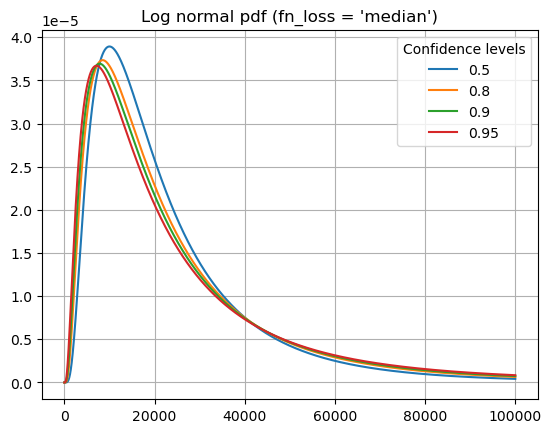

In [10]:
_,ax = plt.subplots()

for conf in [0.5, 0.8, 0.9, 0.95]:
    mu, sigma = df_pred_opt.loc[conf][['mu', 'sigma']].values
    x, pdf = lognormal_pdf(mu, sigma)
    ax.plot(x,pdf,label = f'{conf}')

ax.grid()
ax.legend(title = 'Confidence levels')
ax.set_title("Log normal pdf (fn_loss = 'median')")
plt.savefig('comp_parametric/log_median.png', dpi = 300, bbox_inches ='tight')
plt.show()

In [11]:
fn_loss = 'lower'
df_pred_opt_lw = pd.DataFrame( [get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_95'].values[0],
    upr= df_sp_peak['upper_95'].values[0],
    conf_level = 0.95,
    fn_loss=fn_loss), 
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_90'].values[0],
    upr= df_sp_peak['upper_90'].values[0],
    conf_level = 0.90,
    fn_loss=fn_loss),
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_80'].values[0],
    upr= df_sp_peak['upper_80'].values[0],
    conf_level = 0.80,
    fn_loss=fn_loss),
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_50'].values[0],
    upr= df_sp_peak['upper_50'].values[0],
    conf_level = 0.50,
    fn_loss=fn_loss)], columns = ['mu', 'sigma'], index =[0.95, 0.9, 0.8, 0.5])

df_pred_opt_lw.index.name = 'conf_level'

df_pred_opt_lw[['E(X)', 'Var(X)']] = df_pred_opt_lw.apply(
    lambda row: get_e_and_var(row['mu'], row['sigma']),
    axis=1,
    result_type='expand'  # ensures the tuple is split into two columns
)

df_pred_opt_lw
df_pred_opt_lw.to_csv('comp_parametric/pars_lw.csv')

In [12]:
df_pred_opt_lw

,mu,sigma,E(X),Var(X)
conf_level,,,,
0.95,10.141152,0.785252,34525.807998,1.016395e+09
0.90,10.033347,0.767510,30573.313399,7.499460e+08
0.80,9.942922,0.750256,27566.700964,5.742956e+08
0.50,9.824980,0.720649,23972.139834,3.912941e+08


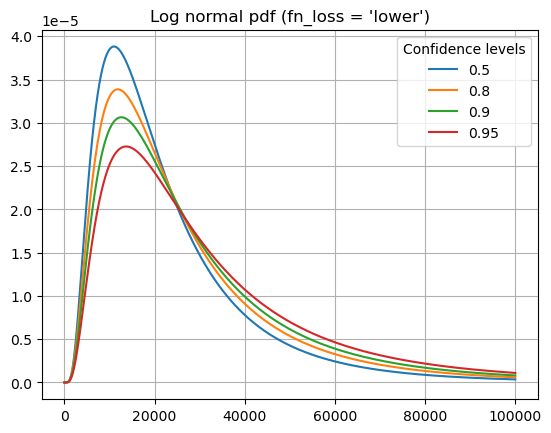

In [13]:
_,ax = plt.subplots()

for conf in [0.5, 0.8, 0.9, 0.95]:
    mu, sigma = df_pred_opt_lw.loc[conf][['mu', 'sigma']].values
    x, pdf = lognormal_pdf(mu, sigma)
    ax.plot(x,pdf,label = f'{conf}')

ax.grid()
ax.legend(title = 'Confidence levels')

ax.set_title("Log normal pdf (fn_loss = 'lower')")
plt.savefig('comp_parametric/log_lower.png', dpi = 300, bbox_inches ='tight')
plt.show()


### Replicate the results using samples from a log normal distribution

In [14]:
lognorm.ppf(
            [0.5, 0.975],
            s=0.8,
            scale=np.exp(10))

array([ 22026.46579481, 105658.89236291])

In [15]:
values = lognorm.rvs(s=0.8, loc=0, scale=np.exp(10), size=1000)

In [16]:
df_log_norm = pd.DataFrame()

df_log_norm['date'] = ['2025-04-13']
df_log_norm['lower_95'] = [np.percentile(values, 2.5)]
df_log_norm['lower_90'] = [np.percentile(values, 5)]
df_log_norm['lower_80'] = [np.percentile(values, 10)]
df_log_norm['lower_50'] = [np.percentile(values, 25)]
df_log_norm['pred'] = [np.percentile(values, 50)]
df_log_norm['upper_95'] =[np.percentile(values, 97.5)]
df_log_norm['upper_90'] = [np.percentile(values, 95)]
df_log_norm['upper_80'] = [np.percentile(values, 90)]
df_log_norm['upper_50'] = [np.percentile(values, 75)]

df_log_norm

,date,lower_95,lower_90,lower_80,lower_50,pred,upper_95,upper_90,upper_80,upper_50
0,2025-04-13,4563.599837,6002.408338,7822.620393,13101.326941,22897.252569,107602.284057,82913.297475,60643.933428,37940.523916


In [17]:
df_sp_peak = df_log_norm

In [18]:
fn_loss = 'median'
df_pred_opt = pd.DataFrame( [get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_95'].values[0],
    upr= df_sp_peak['upper_95'].values[0],
    conf_level = 0.95,
    fn_loss=fn_loss), 
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_90'].values[0],
    upr= df_sp_peak['upper_90'].values[0],
    conf_level = 0.90,
    fn_loss=fn_loss),
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_80'].values[0],
    upr= df_sp_peak['upper_80'].values[0],
    conf_level = 0.80,
    fn_loss=fn_loss),
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_50'].values[0],
    upr= df_sp_peak['upper_50'].values[0],
    conf_level = 0.50,
    fn_loss=fn_loss)], columns = ['mu', 'sigma'], index =[0.95, 0.9, 0.8, 0.5])

df_pred_opt.index.name = 'conf_level'

# Assuming df_pred_opt_ has 'mu' and 'sigma' columns
df_pred_opt[['E(X)', 'Var(X)']] = df_pred_opt.apply(
    lambda row: get_e_and_var(row['mu'], row['sigma']),
    axis=1,
    result_type='expand'  # ensures the tuple is split into two columns
)


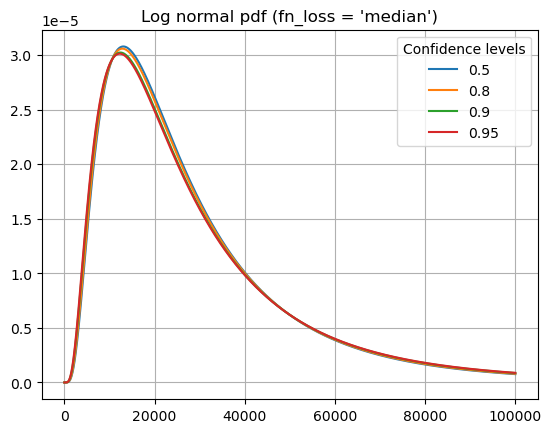

In [19]:
_,ax = plt.subplots()

for conf in [0.5, 0.8, 0.9, 0.95]:
    mu, sigma = df_pred_opt.loc[conf][['mu', 'sigma']].values
    x, pdf = lognormal_pdf(mu, sigma)
    ax.plot(x,pdf,label = f'{conf}')

ax.grid()
ax.legend(title = 'Confidence levels')
ax.set_title("Log normal pdf (fn_loss = 'median')")
#plt.savefig('log_median.png', dpi = 300, bbox_inches ='tight')
plt.show()

In [20]:
fn_loss = 'lower'
df_pred_opt_lw = pd.DataFrame( [get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_95'].values[0],
    upr= df_sp_peak['upper_95'].values[0],
    conf_level = 0.95,
    fn_loss=fn_loss), 
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_90'].values[0],
    upr= df_sp_peak['upper_90'].values[0],
    conf_level = 0.90,
    fn_loss=fn_loss),
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_80'].values[0],
    upr= df_sp_peak['upper_80'].values[0],
    conf_level = 0.80,
    fn_loss=fn_loss),
              get_lognormal_pars(
    med= df_sp_peak['pred'].values[0],
    lwr= df_sp_peak['lower_50'].values[0],
    upr= df_sp_peak['upper_50'].values[0],
    conf_level = 0.50,
    fn_loss=fn_loss)], columns = ['mu', 'sigma'], index =[0.95, 0.9, 0.8, 0.5])

df_pred_opt_lw.index.name = 'conf_level'

df_pred_opt_lw[['E(X)', 'Var(X)']] = df_pred_opt_lw.apply(
    lambda row: get_e_and_var(row['mu'], row['sigma']),
    axis=1,
    result_type='expand'  # ensures the tuple is split into two columns
)

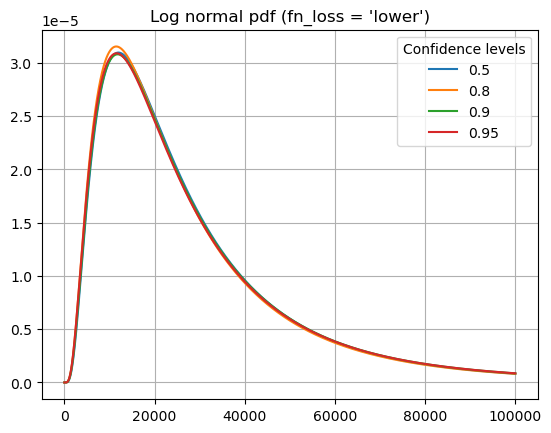

In [21]:
_,ax = plt.subplots()

for conf in [0.5, 0.8, 0.9, 0.95]:
    mu, sigma = df_pred_opt_lw.loc[conf][['mu', 'sigma']].values
    x, pdf = lognormal_pdf(mu, sigma)
    ax.plot(x,pdf,label = f'{conf}')

ax.grid()
ax.legend(title = 'Confidence levels')

ax.set_title("Log normal pdf (fn_loss = 'lower')")
plt.show()